In [63]:
# pip install qulacs numpy
import numpy as np
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import H, SWAP, DenseMatrix

def cphase(control: int, target: int, theta: float):
    """
    Controlled phase: diag(1, 1, 1, e^{i*theta})
    2量子ビットゲートとして DenseMatrix で実装。
    対象ビットの順序は [control, target] とする。
    """
    mat = np.diag([1, 1, 1, np.exp(1j * theta)]).astype(np.complex128)
    return DenseMatrix([control, target], mat)

def qft_circuit(n: int) -> QuantumCircuit:
    """
    QFT (DFT と同じユニタリになる形)
    量子ビットの並び: 0 が LSB（右端）想定。
    """
    qc = QuantumCircuit(n)

    for j in range(n // 2):
        qc.add_gate(SWAP(j, n - 1 - j))

    # 本体部分（H + controlled phase）
    for j in range(n):
        qc.add_gate(H(j))
        for k in range(j + 1, n):
            theta = np.pi / (2 ** (k - j))
            qc.add_gate(cphase(k, j, theta))

    return qc

def iqft_circuit(n: int) -> QuantumCircuit:
    """
    iQFT (QFT の逆。DFT† と同じユニタリになる形)
    """
    qc = QuantumCircuit(n)

    for j in reversed(range(n)):
        for k in reversed(range(j + 1, n)):
            theta = -np.pi / (2 ** (k - j))
            qc.add_gate(cphase(k, j, theta))
        qc.add_gate(H(j))

    for j in range(n // 2):
        qc.add_gate(SWAP(j, n - 1 - j))

    return qc

def basis_state_index_to_bits(idx: int, n: int):
    return "".join(str((idx >> b) & 1) for b in reversed(range(n)))

def pretty_amplitudes(state: QuantumState, n: int, tol: float = 1e-8):
    vec = state.get_vector()
    items = []
    for i, amp in enumerate(vec):
        if abs(amp) > tol:
            bit = basis_state_index_to_bits(i, n)
            items.append(f"|{bit}>: {amp.real:+.6f}{amp.imag:+.6f}j  |amp|^2={abs(amp)**2:.6f}")
    return "\n".join(items) if items else "(all ~0)"

In [65]:
def main():
    n = 3                      # 量子ビット数
    x = 5                      # 入力基底状態 |x> （例: |101> = 5）
    print(f"n={n}, x={x} (|{basis_state_index_to_bits(x,n)}>)")

    # 初期状態 |x>
    st = QuantumState(n)
    st.set_zero_state()
    st.set_computational_basis(x)

    print("\nInitial state:")
    print(pretty_amplitudes(st, n))

    # QFT
    qft = qft_circuit(n)
    st_qft = st.copy()
    qft.update_quantum_state(st_qft)
    print("\nAfter QFT:")
    print(pretty_amplitudes(st_qft, n))

    # iQFT（QFTの逆）
    iqft = iqft_circuit(n)
    st_back = st_qft.copy()
    iqft.update_quantum_state(st_back)
    print("\nAfter iQFT(QFT^-1 ∘ QFT):")
    print(pretty_amplitudes(st_back, n))

    # 元に戻っているか確認
    fidelity = abs(np.vdot(st.get_vector(), st_back.get_vector()))**2
    print(f"\nFidelity with initial state: {fidelity:.12f}")
    return st_qft

st_qft = main()

n=3, x=5 (|101>)

Initial state:
|101>: +1.000000+0.000000j  |amp|^2=1.000000

After QFT:
|000>: +0.353553+0.000000j  |amp|^2=0.125000
|001>: -0.250000-0.250000j  |amp|^2=0.125000
|010>: +0.000000+0.353553j  |amp|^2=0.125000
|011>: +0.250000-0.250000j  |amp|^2=0.125000
|100>: -0.353553+0.000000j  |amp|^2=0.125000
|101>: +0.250000+0.250000j  |amp|^2=0.125000
|110>: -0.000000-0.353553j  |amp|^2=0.125000
|111>: -0.250000+0.250000j  |amp|^2=0.125000

After iQFT(QFT^-1 ∘ QFT):
|101>: +1.000000+0.000000j  |amp|^2=1.000000

Fidelity with initial state: 1.000000000000


Text(0, 0.5, 'angle(deg)')

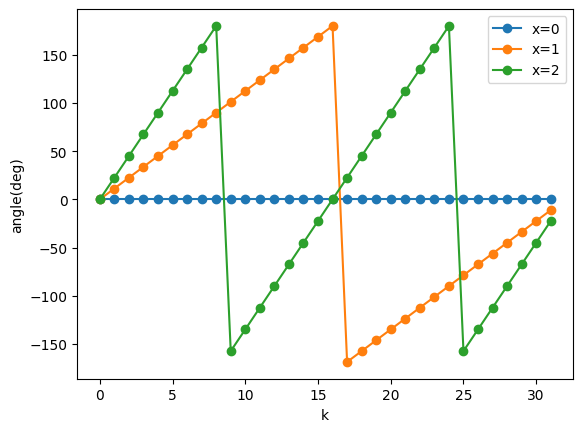

In [66]:
import matplotlib.pyplot as plt

def get_angles(state: QuantumState, n: int, tol: float = 1e-8):
    vec = state.get_vector()
    rs = []
    thetas = []
    for i, amp in enumerate(vec):
        rs.append(abs(amp))
        theta = np.angle(amp, deg=True)
        thetas.append(theta)
    return thetas

n = 5
for x in [0, 1, 2]:
    # 初期状態 |x>
    st = QuantumState(n)
    st.set_zero_state()
    st.set_computational_basis(x)
    
    # QFT
    qft = qft_circuit(n)
    st_qft = st.copy()
    qft.update_quantum_state(st_qft)

    thetas = get_angles(st_qft, n)
    plt.plot(thetas, "o-", label=f"x={x}")
plt.legend()
plt.xlabel("k")
plt.ylabel("angle(deg)")

In [56]:

def classical_qft(vec):
    """定義通りの QFT を行列で実装"""
    N = len(vec)
    j = np.arange(N)
    k = j[:, None]
    F = np.exp(2j * np.pi * k * j / N) / np.sqrt(N)
    return F @ vec


## n=3, x=1 に対する計算
n=3
x=1

## 独自実装
state = QuantumState(n)
state.set_computational_basis(x)  # |001>
qc = qft_circuit(n)
qc.update_quantum_state(state)
psi_qft = state.get_vector()

# 古典的な DFT
psi_in = np.zeros(2**n, dtype=np.complex128)
psi_in[1] = 1.0
psi_dft = classical_qft(psi_in)

print("error:")
print(np.abs(psi_qft-psi_dft))

error:
[5.55111512e-17 6.20633538e-17 5.55111512e-17 6.20633538e-17
 7.04001963e-17 1.14439170e-16 7.04001963e-17 1.11022302e-16]
